# Convolutional Neural Network

* We experiment with the Convolutional Neural Network. 

* We use Standard Scaling for input(X) and Min-Max Scaling for output(Y).

* 12th label parameter (one of the Dihedral angles) had some issues which is fixed. 

* IQR method is used to remove outliers.

In [1]:
import numpy as np # linear algebra
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Output_data_ML.npy')

In [14]:
Y=Y.T
print(np.shape(X),np.shape(Y))

#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
X=(X-x_mean)/x_std


Y[Y[:,11]>2*np.pi,11]=Y[Y[:,11]>2*np.pi,11]-2*np.pi
Y[Y[:,11]<0,11]=Y[Y[:,11]<0,11]+2*np.pi
#Output[:,12:]=Output[:,12:]+2.0*np.pi

#Y=np.log(Y)
R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R,:]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]

#Standard Scaling of Y
y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std

y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std
'''
#Min_Max Scaling of Y
y_min=np.min(Y,axis=0)
Y=Y-y_min
y_max=np.max(Y,axis=0)
Y=Y/y_max
'''
X=np.reshape(X,(-1,38,1))

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.1)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

(1070107, 38) (1070107, 15)
(945049, 38, 1) (945049, 15) (105006, 38, 1) (105006, 15)


In [15]:
print(x_mean,x_std)
np.round(np.std(Y,axis=0),5), np.round(np.mean(Y,axis=0),5)

-0.004383674343281866 0.00966049280916536


(array([1.00003, 1.00005, 1.     , 1.00005, 1.00006, 1.00001, 1.     ,
        1.00003, 1.00004, 1.00003, 1.00004, 1.     , 1.     , 1.     ,
        1.     ], dtype=float32),
 array([ 3.5e-04, -1.0e-05,  4.0e-05,  1.2e-04,  3.1e-04,  1.1e-04,
        -0.0e+00, -1.0e-05,  1.0e-05, -1.0e-05, -1.0e-05, -0.0e+00,
         0.0e+00, -0.0e+00,  0.0e+00], dtype=float32))

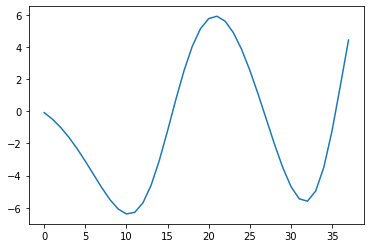

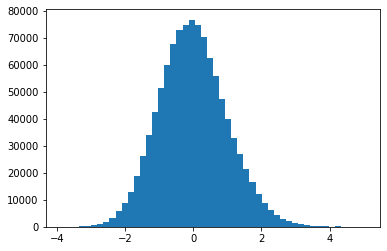

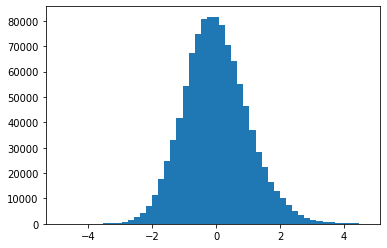

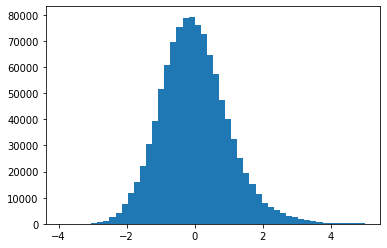

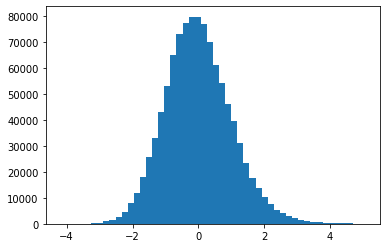

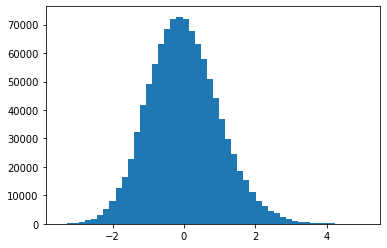

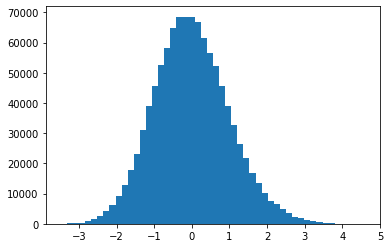

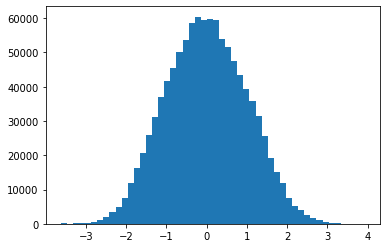

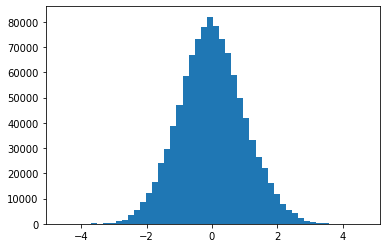

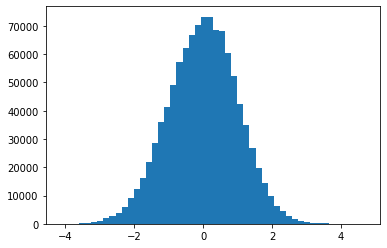

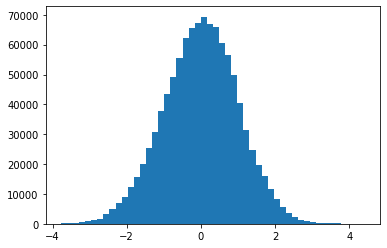

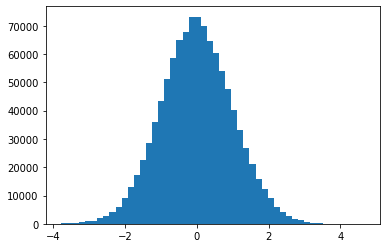

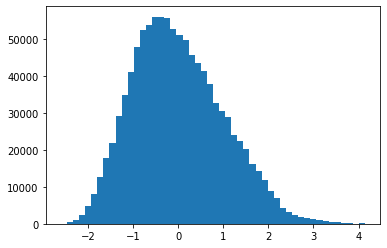

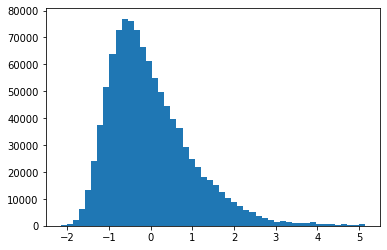

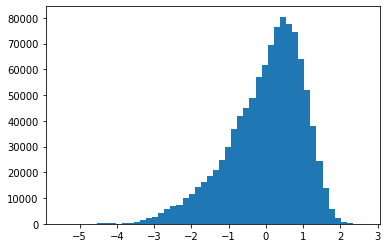

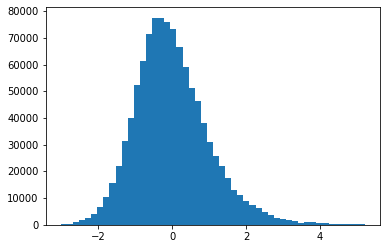

In [16]:
plt.plot(X[10000,:])
plt.show()
for i in range(15):
    plt.hist(Y[:,i],bins=50)
    plt.show()

In [17]:
model = Sequential()


model.add(Conv1D(filters = 30, kernel_size = 5, activation='relu', input_shape = (38,1)))
#model.add(BatchNormalization())
model.add(Conv1D(filters = 60, kernel_size = 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 16, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool1D(strides=2))
model.add(Dropout(0.25))

#model.add(Conv1D(filters = 60, kernel_size = 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 60, kernel_size = 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 32, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool1D(strides=2))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(720, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(360, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(15, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 34, 30)            180       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 60)            9060      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 60)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 60)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 720)               648720    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 720)              

In [18]:
model.compile(loss='mse', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

hist = model.fit(x=xtrain, y=ytrain, batch_size=512,
                           epochs=10, #Increase this when not on Kaggle kernel
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(xtest, ytest), #For speed
                           callbacks=[annealer])

Train on 945049 samples, validate on 105006 samples
Epoch 1/10
945049/945049 [==============================] - 191s 202us/step - loss: 0.6743 - accuracy: 0.2808 - val_loss: 0.5671 - val_accuracy: 0.3270
Epoch 2/10
945049/945049 [==============================] - 194s 205us/step - loss: 0.5864 - accuracy: 0.3147 - val_loss: 0.5507 - val_accuracy: 0.3320
Epoch 3/10
945049/945049 [==============================] - 191s 202us/step - loss: 0.5733 - accuracy: 0.3243 - val_loss: 0.5411 - val_accuracy: 0.3416
Epoch 4/10
945049/945049 [==============================] - 191s 202us/step - loss: 0.5637 - accuracy: 0.3306 - val_loss: 0.5334 - val_accuracy: 0.3588
Epoch 5/10
945049/945049 [==============================] - 192s 203us/step - loss: 0.5564 - accuracy: 0.3364 - val_loss: 0.5204 - val_accuracy: 0.3585
Epoch 6/10
945049/945049 [==============================] - 194s 205us/step - loss: 0.5504 - accuracy: 0.3407 - val_loss: 0.5161 - val_accuracy: 0.3599
Epoch 7/10
945049/945049 [==========

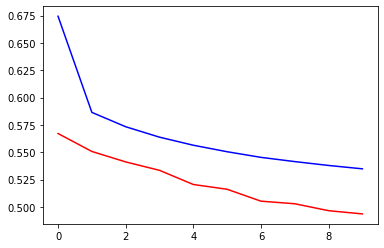

In [19]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [0]:
Y_hat=model.predict(X)

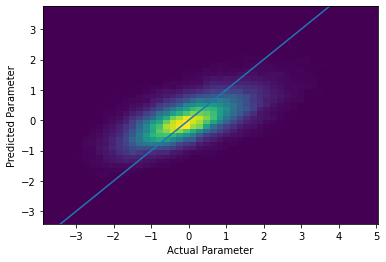

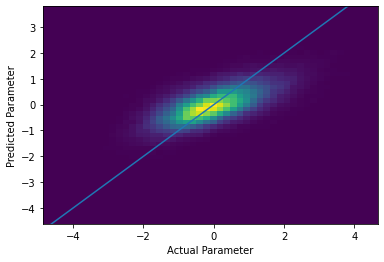

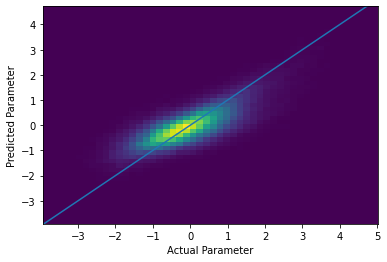

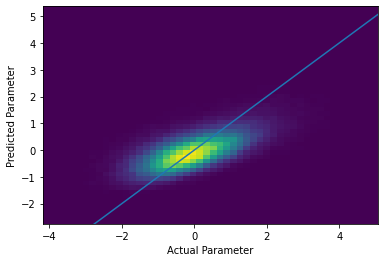

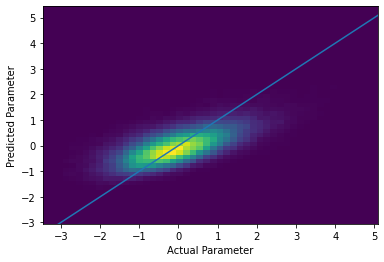

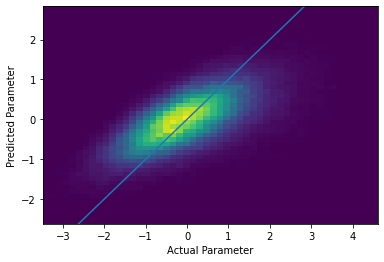

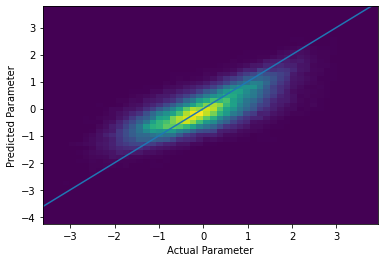

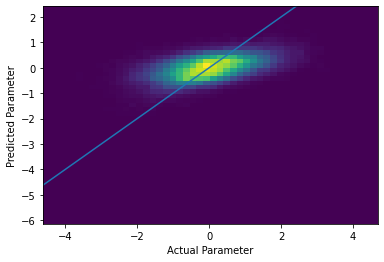

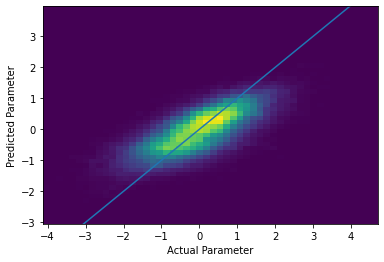

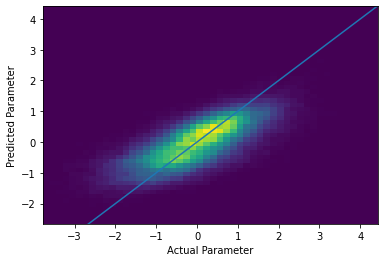

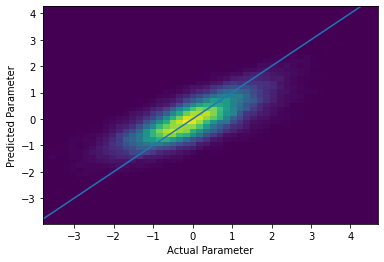

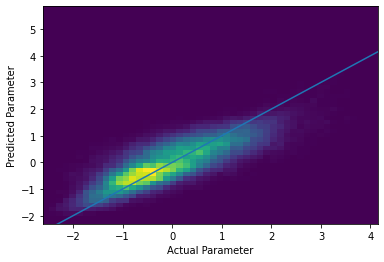

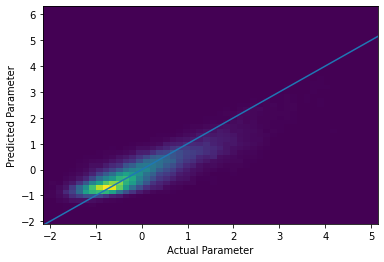

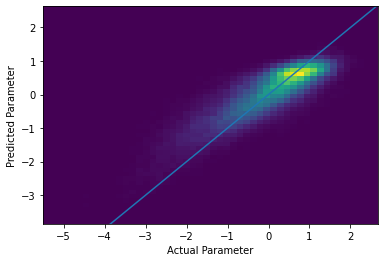

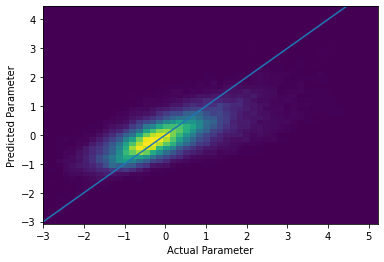

In [22]:
for i in range(15):
  plt.hist2d(Y[:,i],Y_hat[:,i],bins=50)
  plt.xlabel('Actual Parameter')
  plt.ylabel('Predicted Parameter')
  plt.plot(np.arange(np.min(Y),np.max(Y),0.01),np.arange(np.min(Y),np.max(Y),0.01))
  plt.show()